### Principles of Superconducting Quantum Computers
Daniel D. Stancil, Gregory T. Byrd, Wiley, 2002  ISBN: [978-1119750727](https://bcs.wiley.com/he-bcs/Books?action=index&bcsId=12203&itemId=1119750725)

----

## Chapter 1: Qubits, Gates, and Circuits
## Creating a Bell State

In section 1.6, we describe a simple maximally-entangled state, known as a *Bell state*: $$|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

In this notebook, we use Qiskit to create and measure the Bell state, and we explore the creation of other entangled states.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

#### Creating the Circuit

To create the Bell state, we use a CNOT gate where the control qubit is in a superposition of $|0\rangle$ and $|1\rangle$. The target qubit is initialized to $|0\rangle$. 

- When the control qubit is 0, the target qubit is unchanged, resulting in an output state of $|00\rangle$. 
- When the control qubit is 1, the target qubit is flipped, resulting in $|11\rangle$.

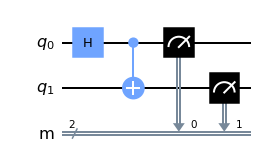

In [2]:
qr = QuantumRegister(2, 'q')
m = ClassicalRegister(2, 'm')
qc = QuantumCircuit(qr,m)
qc.h(0)
qc.cx(0,1)
qc.measure(qr,m)
qc.draw('mpl')

#### Simulate the circuit

To see how the circuit behaves, we run an error-free simulation. The circuit is executed 1024 times, and the simulator keeps track of the different measured outputs, as well as the number of times each output occurs. The results are kept in a Python dictionary object -- you will see the output as a string of two bits ('00' or '11') and the count for each.

You can run this simulation multiple times. You will likely see a slightly different count each time. Because the outcome is probabilistic, and each outcome has a probability of $1/2$, you should see approximately 512 occurrences of '00' and 512 occurrences of '11.

In [3]:
sim = QasmSimulator()
job = execute(qc, sim, shots=1024)
sim_counts = job.result().get_counts()
print(sim_counts)

{'00': 520, '11': 504}


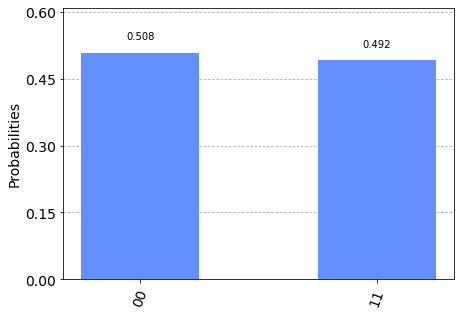

In [4]:
plot_histogram(sim_counts)

To model a more realistic quantum computer, which is not error-free, we add a noise model to the simulator.

In [5]:
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error, depolarizing_error

For this particular example, we set the following error probabilities:

- For the single-qubit Hadamard gate, a Z error (phase flip) occurs with 0.8% probability.
- For the two-qubit CNOT gate, an error occurs with 8% probability. Two-qubit gates are more complex and are significantly more error prone in current quantum hardware.
- Errors can also occur during the measurement process. We give a 3% chance of the measurement being wrong.

In [6]:
# Example noise model, from https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html
# 
p_gate1 = 0.008  
p_gate2 = 0.08   
p_meas = 0.03

# QuantumError objects
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)]) # since the 1q gates is H, we'll do a phase flip
error_gate2 = depolarizing_error(p_gate2, 2)
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise_bit_flip.add_all_qubit_quantum_error(error_meas, ["measure"])

In [7]:
# Create noisy simulator backend
sim_noise = QasmSimulator(noise_model=noise_bit_flip)
job = execute(qc, sim_noise, shots=1024)
noise_sim_counts = job.result().get_counts()
print(noise_sim_counts)

{'00': 506, '11': 436, '10': 44, '01': 38}


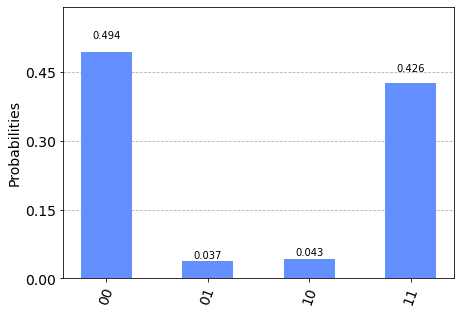

In [8]:
plot_histogram(noise_sim_counts)

When errors occur, incorrect states can be created. In this case we see a small number of '01' and '10' results, although theory tells us that there should be zero probability of seeing these results.

Because the error rate is relatively small, the expected outputs are still the most prevalent.

#### Viewing the State Vector

For some computations, the desire is to create a specific quantum state. As we've discussed, the full quantum state is not accessible on a quantum computer, because we can only measure and get a single (classical) bit string. We cannot see the magnitudes and phases for each basis state.

Luckily, when using a simulator, we have full access to the quantum state. This is a useful tool, when developing or analyzing quantum computations.

If we're only interested in the state vector, we can skip the measurement part of the circuit.  (Measuring would collapse the state and lose the information we're looking for.)

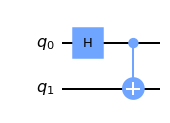

In [9]:
qr = QuantumRegister(2, 'q')
qc = QuantumCircuit(qr)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

In Qiskit, we can use the *state vector simulator*, or we can just allow the system to analyze the unitary transform performed by the circuit and create a state vector object.

In [10]:
bell_sv = Statevector.from_instruction(qc)
print(bell_sv)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


The state vector is printed in computational basis order: 00, 01, 10, 11. This is not easy to interpret, so we can write some code to display the values in a more visually accessible way.

In [11]:
array_to_latex(bell_sv.data)

<IPython.core.display.Latex object>

In [12]:
def binstring(n, bits):
    s = ""
    for b in range(bits-1, -1, -1):
        s += str((n >> b) & 1)
    return s
        

def print_state_vector(sv):
    bits = sv.num_qubits
    vals = sv.dim
    for i in range(0, vals):
        #print_bin(i, bits)
        mag = np.abs(sv.data[i])
        ph = np.angle(sv.data[i], True)  # degrees
        print("{:s}: {:.3f}  mag={:.3f} phase={:.3f} ({:3.2%})".format(binstring(i, bits), sv.data[i], mag, ph, mag**2))   

In [13]:
print_state_vector(bell_sv)

00: 0.707+0.000j  mag=0.707 phase=0.000 (50.00%)
01: 0.000+0.000j  mag=0.000 phase=0.000 (0.00%)
10: 0.000+0.000j  mag=0.000 phase=0.000 (0.00%)
11: 0.707+0.000j  mag=0.707 phase=0.000 (50.00%)


To illustrate the usefulness of showing the state vector, consider another Bell state: $$|\Phi^-\rangle = \frac{1}{\sqrt{2}}(|00\rangle - |11\rangle)$$

There is a local phase difference (of 180 degrees) between the $|00\rangle$ and the $|11\rangle$. We can generate the state by using $|-\rangle$ as the control qubit instead of $|+\rangle$, as shown in the circuit below.

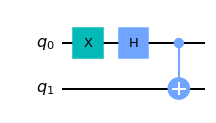

In [14]:
qr = QuantumRegister(2, 'q')
qc = QuantumCircuit(qr)
qc.x(0)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

Viewing the state vector clearly shows the phase difference:

In [15]:
bell_sv = Statevector.from_instruction(qc)
print_state_vector(bell_sv)

00: 0.707+0.000j  mag=0.707 phase=0.000 (50.00%)
01: 0.000+0.000j  mag=0.000 phase=0.000 (0.00%)
10: 0.000+0.000j  mag=0.000 phase=0.000 (0.00%)
11: -0.707+0.000j  mag=0.707 phase=180.000 (50.00%)


However, if we simulate and measure, the outcome is the same as the previous Bell state. The phase is not seen by the measurement, and the magnitude determines the probability. Since the magnitude is the same as before, both outcomes have a 50% chance of being observed.

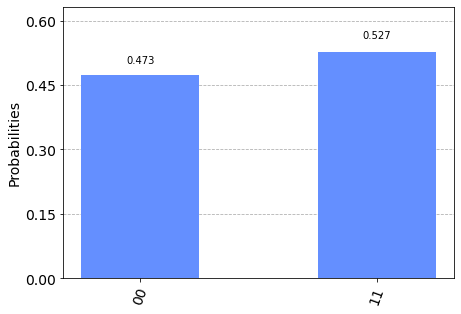

In [16]:
m = ClassicalRegister(2, 'm')
qc.add_register(m)
qc.measure(qr, m)
job = execute(qc, sim, shots=1024)
sim_counts = job.result().get_counts()
plot_histogram(sim_counts)

#### Exercises

There are a total of four Bell state -- two more, in addition to the ones shown above.
$$|\Psi^+\rangle = \frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$$
$$|\Psi^-\rangle = \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle)$$

In the cells below, create circuits to generate the desired states, and show the state vectors when the circuits are applied to a starting state of $|00\rangle$.

- Circuit for $|\Psi^+\rangle$

- State vector for $|\Psi^+\rangle$

- Circuit for $|\Psi^-\rangle$

- State vector for $|\Psi^-\rangle$

----

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table